# Détection d'anomalies non supervisée par LBP et OCSVM sur le jeu de données MVTEC AD sur des images de texture

Nous allons dans ce mini projet reconnaître les défauts industriels à partir de la base de données MVTEC AD. Détecter les anomalies est une nécessité pour les industriels afin de satisfaire au mieux les clients et d'être le plus rentable.

# 1. Workflow - LBP + OCSVM pour détection d'anomalies (MVTec AD)

* Charger les images normales d'entraînement et les images de test et leurs masques
* Extraire les descripteurs d'histogrammes LBP sur des patches des images normales avec `local_binary_pattern()`
* Entraîner le modèle One-Class SVM (`sklearn.svm.OneClassSVM`) sur ces descripteurs
* Appliquer le modèle sur les patches des images de test pour obtenir les prédictions normales/anormales (`predict`) et les scores de décision (`decision_function`)
* Reconstruire une carte d’anomalie (anomaly map) à partir des scores de décision par patch sur des images de test
* Comparer les cartes d’anomalie avec les masques ground truth pour évaluation (`AUROC`, `FPR`, `FNR`) tout en touvant le seuil sur la carte d'anomalies qui les maximise ou minimise

# 2. Bibliothèques nécesssaires

In [2]:
import numpy as np
import cv2
import joblib
from skimage.feature import local_binary_pattern
from skimage.util import view_as_windows
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import OneClassSVM
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import pandas as pd
import joblib

# 3. Explore le dataset

Afin de mieux gérer le dataset, nous avons essayer de concevoir une classe comme on le fait avec les modèles datasets de pytorch ou tensorflow pour le deep learning qui se base sur le code (https://github.com/amazon-science/patchcore-inspection/blob/main/src/patchcore/datasets/mvtec.py), mais adapté pour correspondre au machine learning. Voici les étapes de ce code:
* Charge les images et masques du dataset MVTec AD
* Gère les splits : train, test, val
* Applique des transformations (resize, NDG, normalisation)
* Retourne un dictionnaire avec : image, masque, classe, anomalie, chemin

### 3.1 Train Images

In [3]:
data = "../data"
classname = 'carpet'

train set length :  280
image shape :  (256, 256)


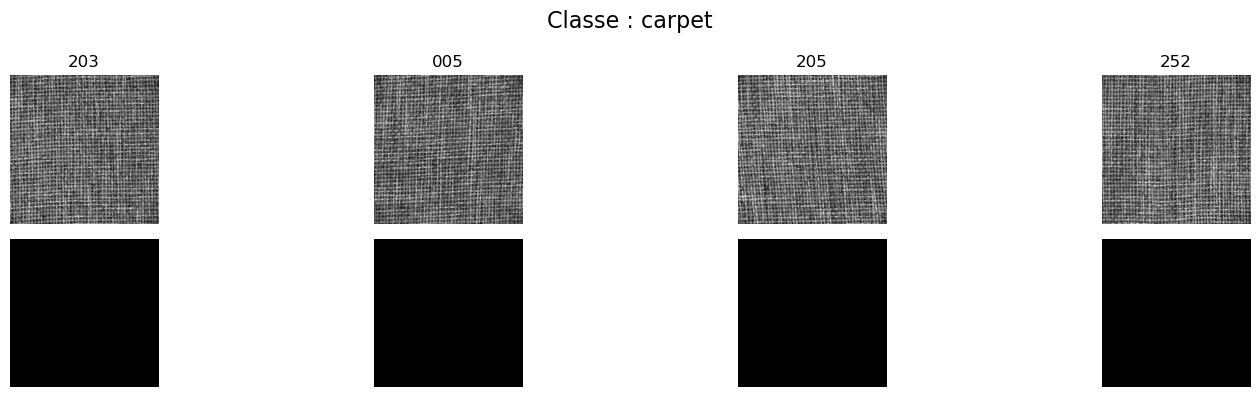

In [4]:
from datasets.mvtecad import DatasetSplit, MVTecDataset, Transform
from detections.utils import afficher_images_test, set_seed, show_train_set

# Prétraitement pour LBP (image en NDG, pas de normalisation)
transform = Transform(size=(256, 256), to_gray=True, normalize=False)

# Set seed for reproductibility
set_seed()

train_set = MVTecDataset(
        source=data,
        classname=classname,
        split=DatasetSplit.TRAIN,
        train_val_split=1.0,
        transform=transform,
        shuffle=True
    )



"""val_set = MVTecDataset(
    source= data,
    classname=classname,
    split=DatasetSplit.VAL,       
    train_val_split=0.8,
    shuffle=True
)"""

print("train set length : ", len(train_set))

print("image shape : ", train_set[1]['image'].shape)

n_images = 4
show_train_set(train_set, n_images)


In [4]:
#print(np.unique(train_set[0]['image']))

### 3.2 Explore test Set images

Type de split : <enum 'DatasetSplit'> DatasetSplit.TEST
(256, 256)
(256, 256)
[0]


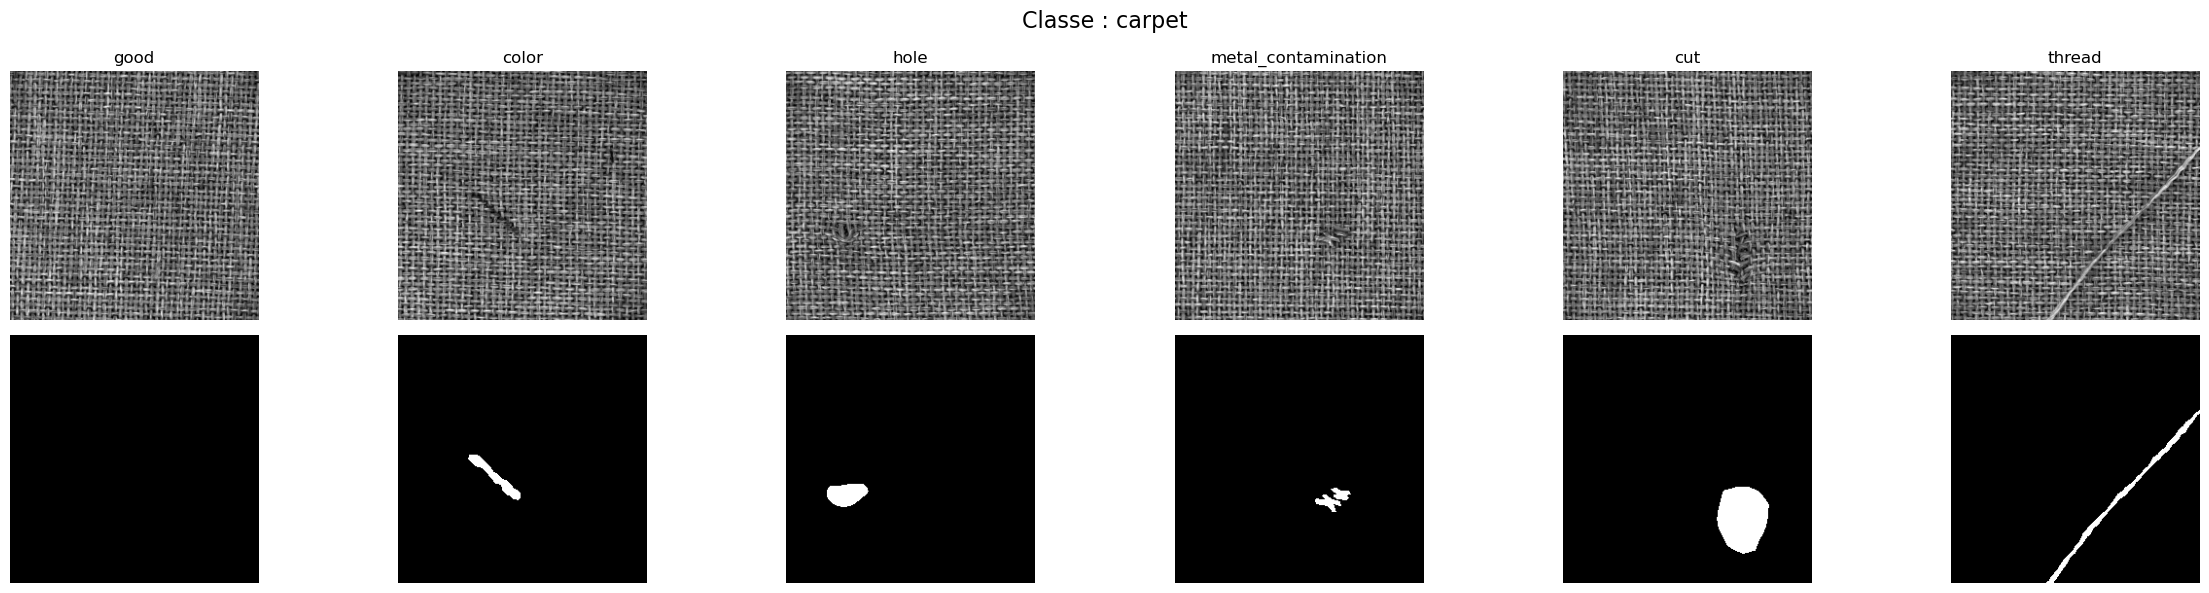

In [5]:
test_set = MVTecDataset(
        source="../data",
        classname=classname,
        split=DatasetSplit.TEST,
        train_val_split=1.0,
        transform=transform,
        shuffle=False
    )
print("Type de split :", type(test_set.split), test_set.split)

print(test_set[1]['image'].shape)
print(test_set[1]['mask'].shape)
print(np.unique(test_set[1]['mask'])) 
#Afficher quelques images de test et leur masque
afficher_images_test(test_set)

# 4. Récupérer toutes les images  d'entrainement et ainsi que leur masque.

In [6]:
images_train = [sample["image"] for sample in train_set]
images_train = images_train[:200]  # ou random.sample(images_train, 200)
#images_val = [sample["image"] for sample in val_set]
#ground_truth_masks = [sample["mask"] for sample in train_set]

# 5.  Calculer le descripteur LBP de chaque image et le diviser en  N patches

* Applique LBP sur chaque image (texture locale)
* Découpe l’image en patches glissants
* Calcule un histogramme LBP par patch
* Retourne un ensemble de vecteurs de caractéristiques (1 par patch)

Le descripteur LBP dépend d'un rayon  **R** (taile de la fenêtre) et d'un nombre  de points **P**. Plus le rayon est grand, plus on capture des textures à grande échelle, ce qui rend  le descripteur plus robuste au bruit. À l'inverse, plus le rayon est petit, plus on détecte textures fines, mais on devient très sensible aux petites variations locales, ce qui donne moins d'informations sur la texture globale de l'image.

De la même façon, le nombre de points **P** influence la précision de la description : plus **P** est élevé, plus on capte de détails autour du pixel central, mais cela peut aussi rendre le descripteur plus complexe et plus sensible au bruit.

Les descripteurs utilisés dans ce projet sont les histogrammes du LBP naturel ou du LBP uniforme. Le LBP naturel encode la différence entre les voisins et le pixel central. Si un voisin est supérieur au pixel central, il reçoit le chiffre binaire 1, sinon 0. Ensuite, en suivant le sens des aiguilles d’une montre, on récupère ces bits dans la fenêtre pour les convertir en un nombre décimal : c’est ce nombre qui représente le code LBP. Dans ce cas l'histogramme LBP est très détaillé  **2^P** bins.

Le LBP uniforme, lui, ne se concentre pas directement sur la différence pixel par pixel, mais plutôt sur le nombre de transitions entre 0 et 1 dans la séquence binaire lue dans le sens horaire. Un motif est dit uniforme s’il contient au plus deux transitions entre 0 et 1 (ou 1 et 0). Ces motifs uniformes reçoivent leur valeur exactement comme dans le LBP naturel. Les motifs non-uniformes, eux, sont tous regroupés dans une seule et même catégorie. L’histogramme du LBP uniforme est donc constitué de P + 2 bins, le dernier bin étant réservé à tous les motifs non-uniformes.

In [7]:
import numpy as np
from skimage.feature import local_binary_pattern
from skimage.util import view_as_windows
from sklearn.base import BaseEstimator, TransformerMixin

class LBPPatchHistogram(BaseEstimator, TransformerMixin):
    def __init__(self, radius=1, n_points=8, method="default", patch_size=(16, 16), step=None, per_image=False):
        self.radius = radius
        self.n_points = n_points
        self.method = method
        self.patch_size = patch_size
        self.step = step or patch_size[0]
        self.per_image = per_image

    def _patch_histograms(self, lbp_image, n_bins):
        patches = view_as_windows(lbp_image, self.patch_size, step=self.step)
        histograms = []
        for i in range(patches.shape[0]):
            for j in range(patches.shape[1]):
                patch = patches[i, j]
                hist = np.histogram(patch, bins=n_bins, range=(0, n_bins))[0]
                hist = hist / (hist.sum() + 1e-6)
                histograms.append(hist)
        return np.array(histograms)

    def transform(self, X):
        n_bins = self.n_points + 2 if self.method == 'uniform' else (2**self.n_points)//2
        if self.per_image:
            features = []
            for img in X:
                lbp = local_binary_pattern(img, self.n_points, self.radius, self.method)
                histos = self._patch_histograms(lbp, n_bins)
                features.append(histos)
            return np.array(features)  # shape: (n_images, n_patches, n_bins)
        else:
            features = []
            for img in X:
                lbp = local_binary_pattern(img, self.n_points, self.radius, self.method)
                features.extend(self._patch_histograms(lbp, n_bins))
            return np.array(features)  # shape: (n_patches_total, n_bins)

    def fit(self, X, y=None):
        return self




#extractor = LBPPatchHistogram(flatten=True)
#features_train = extractor.transform(images_train)  # shape = (n_train_images, n_patches * n_bins)


#method = 'uniform'
#images = [images_train[0], images_train[1]]
#extractor = LBPPatchHistogram(patch_size=(32, 32), step=32, per_image=True, method=method)
#features = extractor.transform(images)

#print(features.shape)  # (nombre_images, nombre_patches_par_image, nombre_bins)


In [8]:
#histograms_first_image = features[0]  # shape = (n_patches, n_bins)

#from detections.detector import PatchViewer

#PatchViewer.show_histograms(histograms_first_image)

In [9]:
#patch_idx1 = 5
#patch_idx2 = 10

#h1 = histograms_first_image[patch_idx1].astype(np.float32)
#h2 = histograms_first_image[patch_idx2].astype(np.float32)

#dist_bhatt = cv2.compareHist(h1, h2, cv2.HISTCMP_BHATTACHARYYA)
#dist_corr = cv2.compareHist(h1, h2, cv2.HISTCMP_CORREL)
#dist_chisqr = cv2.compareHist(h1, h2, cv2.HISTCMP_CHISQR)
#dist_intersect = cv2.compareHist(h1, h2, cv2.HISTCMP_INTERSECT)
#dist_KL = cv2.compareHist(h1, h2, cv2.HISTCMP_KL_DIV)

#print("Bhattacharyya distance:", dist_bhatt)
#print("Correlation:", dist_corr)
#print("Chi-Square:", dist_chisqr)
#print("Intersection:", dist_intersect)
#print("KL DIV:", dist_KL)

# 6. Recherche des meilleurs paramètres

* Définir un pipeline : LBP + StandardScaler + OneClassSVM
* Explorer plusieurs hyperparamètres via GridSearchCV
* Utiliser un scorer personnalisé basé sur la variance des scores
* Entraîne le modèle sur des images normales uniquement
* Sélectionne le meilleur modèle trouvé
* Sauvegarde :
    * le modèle OCSVM
    * le pipeline complet
    * les résultats de la recherche au format CSV

L’OCSVM est un estimateur qui vise à séparer les données de l’origine. Il s’inscrit dans le cadre de la détection d’anomalies non supervisée. Pour ce faire, il est entraîné uniquement sur des images qu’on suppose normales, afin d’apprendre leur distribution. Lors du test, il attribue un score de décision à chaque donnée : plus ce score est élevé, plus la donnée est considérée comme normale. À l’inverse, un score inférieur à zéro indique une anomalie.
Il possède un hyperparamètre important : le paramètre $\nu \in [0,1]$, qui contrôle la proportion maximale de données normales autorisées à être considérées comme anormales, et la proportion minimale de vecteurs de support.
Si le noyau utilisé est gaussien (RBF), un autre paramètre, gamma, contrôle l’influence d’un seul point : plus gamma est grand, plus la courbe de décision est fine et sensible aux variations locales.

In [10]:
# Pipeline
method='uniform'

pipeline = Pipeline([
    ('lbp_patches', LBPPatchHistogram(method=method, per_image=False)),  
    ('scaler', StandardScaler()),
    ('ocsvm', OneClassSVM())
])

# Grille de recherche
param_grid = {
    'lbp_patches__radius': [1, 2, 3],
    'lbp_patches__n_points': [8, 11],
    'lbp_patches__patch_size': [(32, 32)],
    'lbp_patches__step': [8],
    'ocsvm__nu': [0.1, 0.15, 0.20],
    'ocsvm__gamma': [0.1, 0.15, 0.20]
}

# Scorer personnalisé
def anomaly_scorer(estimator, X):
    scores = estimator.decision_function(X)
    return -np.var(scores)  # Moins de variance = plus de cohérence pour des données normales

#custom_scorer = make_scorer(anomaly_scorer, greater_is_better=True, needs_y=False)


# GridSearch
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=2,
    scoring=anomaly_scorer,
    n_jobs=-1,
    verbose=2
)

# Entraînement (sur images normales)
grid_search.fit(images_train)

# Meilleur modèle
best_model = grid_search.best_estimator_
print("Meilleurs paramètres :", grid_search.best_params_)

# Sauvegarde du modèle OCSVM
joblib.dump(best_model.named_steps['ocsvm'], "meilleur_modele_ocsvm_32_8_u.joblib")

# Sauvegarde complète du pipeline
joblib.dump(best_model, "pipeline_complet_32_8_u.joblib")

# Export résultats au format CSV
results_df = pd.DataFrame(grid_search.cv_results_)
results_df.to_csv("resultats_gridsearch_32_8_u.csv", index=False)

Fitting 2 folds for each of 54 candidates, totalling 108 fits
[CV] END lbp_patches__n_points=8, lbp_patches__patch_size=(32, 32), lbp_patches__radius=1, lbp_patches__step=8, ocsvm__gamma=0.1, ocsvm__nu=0.2; total time= 4.5min
[CV] END lbp_patches__n_points=8, lbp_patches__patch_size=(32, 32), lbp_patches__radius=2, lbp_patches__step=8, ocsvm__gamma=0.15, ocsvm__nu=0.15; total time= 4.4min
[CV] END lbp_patches__n_points=8, lbp_patches__patch_size=(32, 32), lbp_patches__radius=3, lbp_patches__step=8, ocsvm__gamma=0.15, ocsvm__nu=0.15; total time= 3.7min
[CV] END lbp_patches__n_points=11, lbp_patches__patch_size=(32, 32), lbp_patches__radius=1, lbp_patches__step=8, ocsvm__gamma=0.15, ocsvm__nu=0.1; total time= 2.8min
[CV] END lbp_patches__n_points=11, lbp_patches__patch_size=(32, 32), lbp_patches__radius=2, lbp_patches__step=8, ocsvm__gamma=0.1, ocsvm__nu=0.1; total time= 2.8min
[CV] END lbp_patches__n_points=11, lbp_patches__patch_size=(32, 32), lbp_patches__radius=2, lbp_patches__step=8

# 7. Génération de la carte d'anomalies
- Appliquer LBP sur l’image pour extraire les motifs locaux
- Découper l’image en patches glissants
- Calculer un score d’anomalie par patch avec OCSVM
- Répartir les scores sur tous les pixels couverts par chaque patch
- Faire une moyenne des scores par pixel (accumulation pondérée)
- Produire une carte d’anomalie normalisée (valeurs entre 0 et 1)

In [8]:
def generate_anomaly_map(image, lbp_transformer, ocsvm_model, upscale=True):
    # 1. Image LBP
    lbp = local_binary_pattern(
        image,
        lbp_transformer.n_points,
        lbp_transformer.radius,
        lbp_transformer.method
    )

    # 2. Découpage des patchs
    patch_size = lbp_transformer.patch_size
    step = lbp_transformer.step or patch_size[0]
    patches = view_as_windows(lbp, patch_size, step=step)
    h, w = patches.shape[:2]
    
    # 3. Initialisation de la carte de score (taille originale)
    scores_map = np.zeros_like(image, dtype=np.float32)
    counts_map = np.zeros_like(image, dtype=np.float32)

    n_bins = lbp_transformer.n_points + 2 if lbp_transformer.method == 'uniform' else (2**lbp_transformer.n_points)//2

    # 4. Score par patch et contribution aux pixels couverts
    for i in range(h):
        for j in range(w):
            # Calcul du score du patch (comme avant)
            patch = patches[i, j]
            hist = np.histogram(patch, bins=n_bins, range=(0, n_bins))[0]
            hist = hist / (hist.sum() + 1e-6)
            score = -ocsvm_model.decision_function([hist])[0]
            
            # Zone du patch dans l'image originale
            y_start, x_start = i * step, j * step
            y_end, x_end = y_start + patch_size[0], x_start + patch_size[1]
            
            # Ajout du score aux pixels couverts (moyenne pondérée)
            scores_map[y_start:y_end, x_start:x_end] += score
            counts_map[y_start:y_end, x_start:x_end] += 1

    # 5. Normalisation (moyenne par pixel)
    scores_map = np.divide(scores_map, counts_map) #, where=(counts_map > 0)
    
    # 6. Normalisation finale [0, 1]
    scores_map -= scores_map.min()
    if scores_map.max() > 0:
        scores_map /= scores_map.max()

    return scores_map



# 8. Résultats

In [9]:

# Chargement ultérieur
pipeline = joblib.load("pipeline_complet_32_8_u.joblib")

# Accès aux étapes
lbp = pipeline.named_steps['lbp_patches']
ocsvm = pipeline.named_steps['ocsvm']



# Si tu as sauvegardé uniquement le modèle OCSVM
#ocsvm_model = OCSVMAnomalyDetector.load("meilleur_modele_ocsvm.joblib")

# Si tu veux prédire sur de nouvelles images :
#X_test_transformed = lbp_transformer.transform(X_test)
#X_test_scaled = best_model.named_steps['scaler'].transform(X_test_transformed)
#preds = ocsvm_model.predict(X_test_scaled)



In [10]:
import matplotlib.pyplot as plt

def show_results(images, anomaly_maps, gt_masks, idx=0):
    plt.figure(figsize=(15,5))

    plt.subplot(1,3,1)
    plt.imshow(images[idx], cmap='gray')
    plt.title("Image originale")
    plt.axis('off')

    plt.subplot(1,3,2)
    #from scipy.ndimage import gaussian_filter
    #smoothed = gaussian_filter(anomaly_maps[idx], sigma=8)
    plt.imshow(1-anomaly_maps[idx], cmap='jet')
    plt.title("Carte d'anomalie")
    #plt.colorbar()
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.imshow(gt_masks[idx], cmap='gray')
    plt.title("Masque de vérité")
    plt.axis('off')

    plt.show()


# Données de test
images_test = [sample['image'] for sample in test_set]
print(len(images_test))
gt_masks = [sample['mask'] for sample in test_set]
print(len(gt_masks))
anomalies_map = []

# Prédiction
for img in images_test:
    anomaly_map = generate_anomaly_map(img, lbp, ocsvm)
    anomalies_map.append(anomaly_map)
    


117
117


(256, 256)
(256, 256)
[0.         0.02139166 0.06436677 ... 0.981885   0.9820987  1.        ]


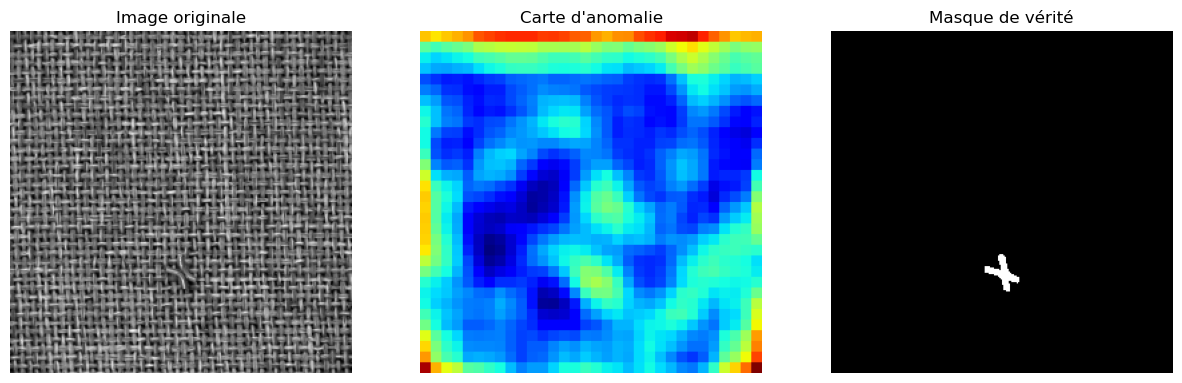

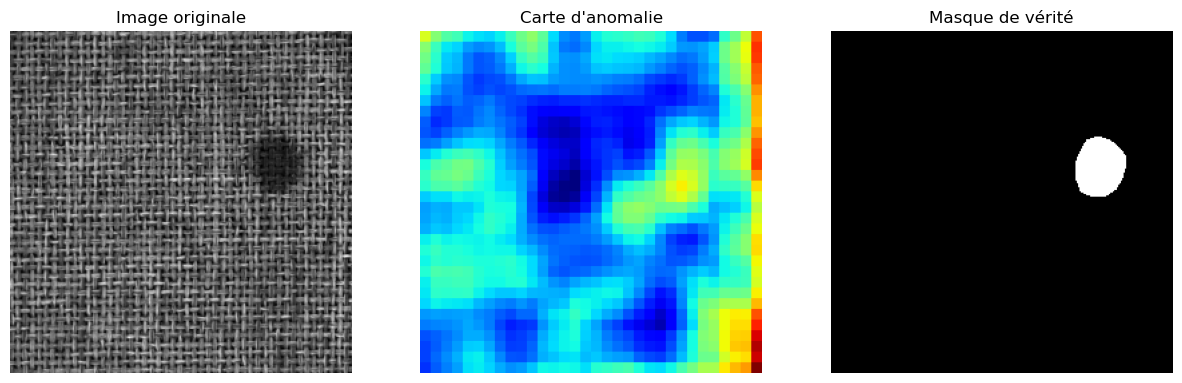

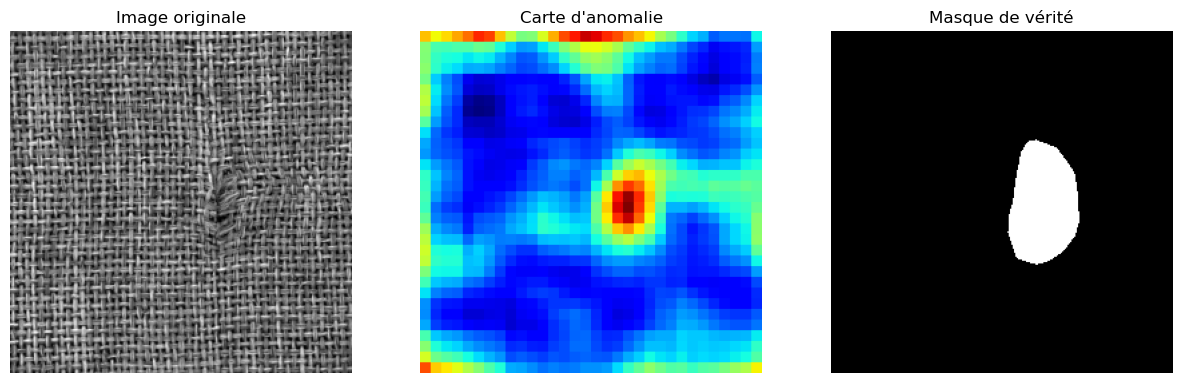

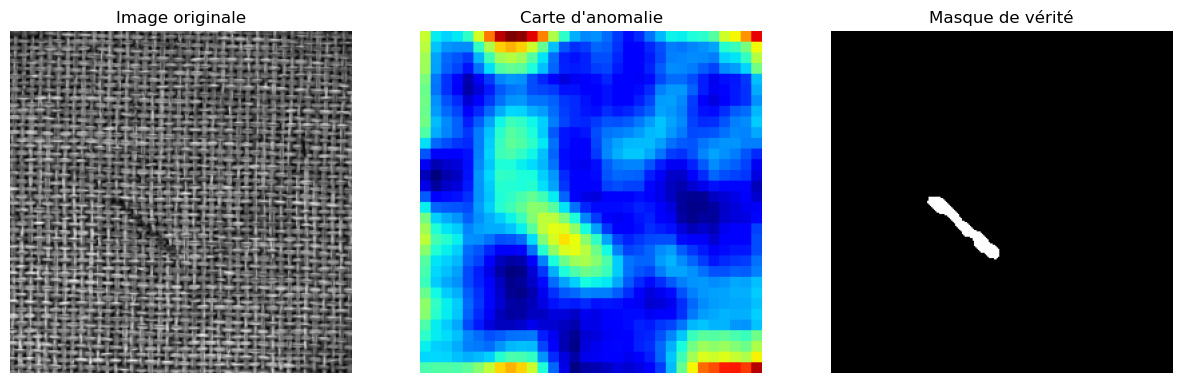

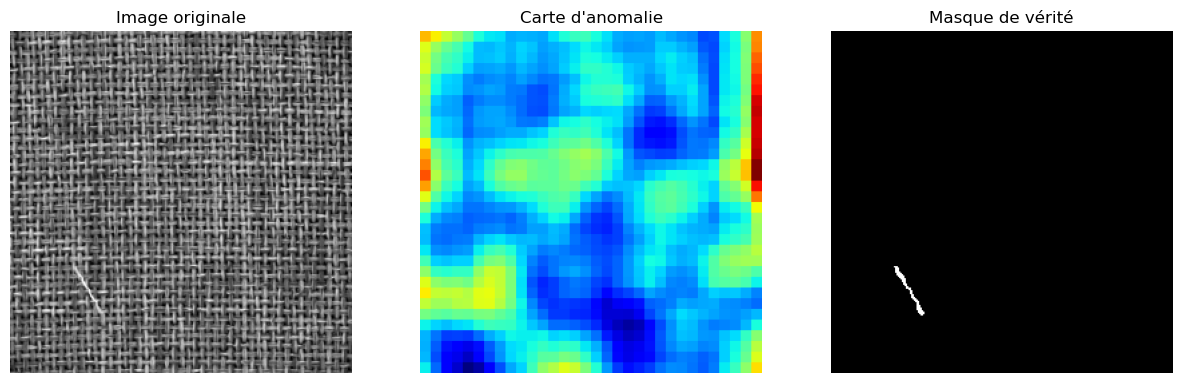

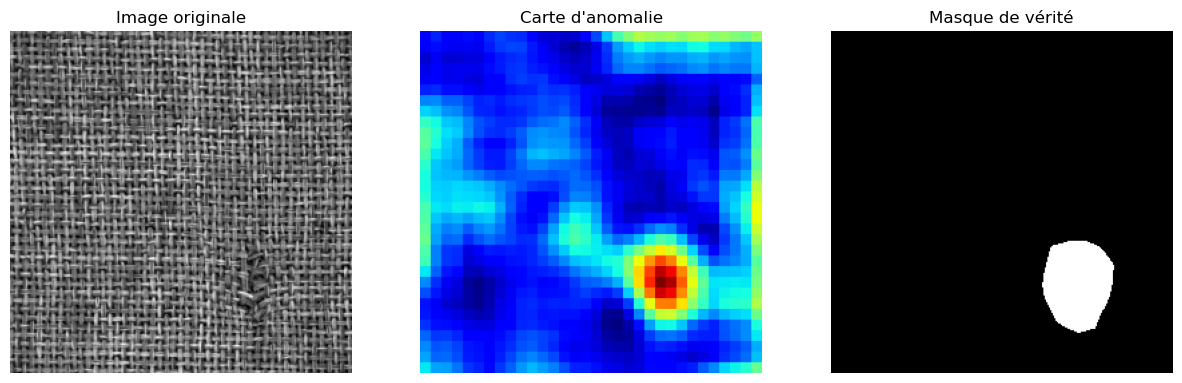

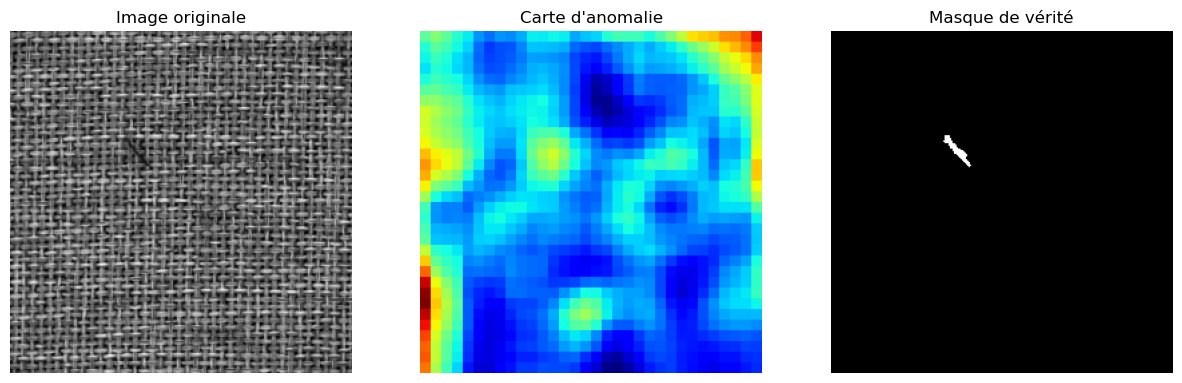

In [18]:
print(images_test[50].shape)
print(anomalies_map[50].shape)
print(np.unique(anomaly_map))

# Résultats image
import random
random.seed(5)
random_indices = random.sample(range(len(images_test)), 7)
for idx in random_indices:
    show_results(images_test, anomalies_map, gt_masks, idx=idx)

In [14]:
from metrics import compute_pixelwise_retrieval_metrics
# Évaluation
results = compute_pixelwise_retrieval_metrics(anomalies_map, gt_masks)

print("AUROC:", results["auroc"])
print("Optimal threshold:", results["optimal_threshold"])
print("Optimal FPR:", results["optimal_fpr"])
print("Optimal FNR:", results["optimal_fnr"])

AUROC: 0.08556270685203612
Optimal threshold: 0.0
Optimal FPR: 0.9839752718933628
Optimal FNR: 0.0
